In [47]:
# Define colors
Pitt.Blue<- "#003594"
Pitt.Gold<-"#FFB81C"
Pitt.DGray <- "#75787B"
Pitt.Gray <- "#97999B"
Pitt.LGray <- "#C8C9C7"
# ggplot preferences
library("ggplot2")
library("repr")
options(repr.plot.width=10, repr.plot.height=10/1.68)
Pitt.Theme<-theme( panel.background = element_rect(fill = "white", linewidth = 0.5, linetype = "solid"),
  panel.grid.major = element_line(linewidth = 0.5, linetype = 'solid', colour =Pitt.Gray), 
  panel.grid.minor = element_line(linewidth = 0.25, linetype = 'solid', colour = "white")
)
base<- ggplot() +aes()+ Pitt.Theme

# Categorical Data: Binomial Outcomes
----
Keeping similar explanatory variables from before, let's generate some binary outcome data with the *logit* link function.

The expected value $\mu$ of a binary outcome is just the probability $p$ that it takes value one, so the logit link function is given by:
$$\eta=\log\left(\frac{\mu}{1-\mu}\right)=\log\left(\frac{p}{1-p}\right)=\log\left(\frac{\Pr\left\{X=1\right\}}{\Pr\left\{X=0\right\}}\right)$$ 

That is, the linear model we will specify for the data will be used to represent the log of the *odds ratio* for a success.

One way of viewing this, is that by specifying a linear model $\eta_i=x_i^T \beta$ for the log-odds-ration, we're really modeling the odds ratio as the product each term, with exponential growth in each:
$$ \frac{\Pr\left\{X=1\right\}}{\Pr\left\{X=0\right\}}=\frac{p}{1-p}=\exp(x_i^T \beta)=e^{\beta_0}e^{\beta_1x_{i1}}\cdots e^{\beta_{k}x_{ik}}$$

We can invert the log-odds ratio to get a formula for the probability:
    $$\eta=\log\left(\frac{p}{1-p}\right),$$
where this leads us to a success probability given by:
    $$\Pr\left\{ X=1\right\}=p=\frac{\exp(\eta)}{ 1+\exp(\eta)}=\frac{\exp(x_i^T \beta)}{ 1+\exp(x_i^T \beta)}$$

So let's set that up with some controlled data, give it some framing, and feed that into a Binomial GLM!

In [ ]:
Ndata <- 1000
x1 <- ifelse(runif(Ndata)<0.5,0,1)
x2.0 <- rnorm(Ndata,mean=2.1,sd=0.8)
x2.1 <- rnorm(Ndata,mean=2.5,sd=0.9)
x2 <- ifelse(x1==1,x2.1,x2.0)
beta <- c(-2.5, 2 , 1/2 )
# make the true linear predictor
eta <- beta[1]+beta[2]*x1 +beta[3]*x2
# Make the probability
p.mean <- exp(eta)/(1+exp(eta))
# Draw a Bernoulli from the releveant distribution
generateY.binary <- function(p.i) ifelse(p.i>=runif(1),TRUE,FALSE)
binary.outcome <- sapply(p.mean,generateY.binary)

Putting this data into a data frame:

In [ ]:
data.Bernoulli <- data.frame(own.multiple.cars=as.factor(binary.outcome),
                             married=as.factor(x1),
                             hh.income=round( exp(8)*exp(x2),-1))
head(data.Bernoulli)

So, given this *binary* variable we can extract estimates from the data using the standard link function for *binomial* data in the GLM the *logit* link. (Note that $n=1$ is a very simple, special case of a binomial, which is also referred to as a Bernoulli random variable)

In [ ]:
glm.binomial <- glm( own.multiple.cars~ married+log(hh.income), data=data.Bernoulli, family= 'binomial' )
summary( glm.binomial )
beta.binom <- coef(  glm.binomial  )
# True Value: c(-5.5 , 2, 1/2)

Note that here we are modeling the log odds-ratio for a success/failure through the variables $x_1$ and $x_2$, so that means that the odds ratio is given by:
$$\begin{eqnarray} \frac{\Pr\left\{\text{Success}\right\}}{\Pr\left\{\text{Failure}\right\}} &=& \exp\left\{-4+\delta_\text{married}+\tfrac{1}{2}\log(x_\text{income})\right\} \\ &=& \exp\left\{-4\right\}\cdot \exp\left\{\delta_\text{married}\right\}\cdot \exp\left\{\tfrac{1}{2}\log(x_\text{income})\right\} \\
 &=&  \exp\left\{-4\right\}\cdot \exp\left\{\delta_\text{married}\right\} \sqrt{x_\text{income}}
\end{eqnarray}$$

So our induced odds ratio relationship is:

In [ ]:
theory.or <- function(income,married=FALSE) exp(-6.5 + 2*married)*sqrt(income)

and the estimated one is:

In [ ]:
est.or <- function(income,married=FALSE) exp(beta.binom[1]+married*beta.binom[2] +beta.binom[3]*log(income))

So we can graph the estimated odds ratio for income for a married person (the gold line) in comparison to the induced theoretical relationship (the blue line)

In [ ]:
base+geom_function( fun = est.or, args=list(married=TRUE), color=Pitt.Blue, linewidth=2,) +
geom_function( fun = theory.or,args=list(married=TRUE), color=Pitt.Gold, linewidth=2) +
xlim(5000, 250000)+ylab("Odds ratio for multiple cars")+xlab("x2") 

And for a single person

In [ ]:
base + geom_function( fun = est.or, args=list(married=FALSE), color=Pitt.Blue, linewidth=2,) +
geom_function( fun = theory.or,args=list(married=FALSE), color=Pitt.Gold, linewidth=2) +
xlim(5000, 250000)+ylab("Odds ratio for multiple cars")+xlab("x2")

Odds ratios are a bit more intuitive to explain to people: 
* So for a married household at 100k income, the chance they have multiple cars is 3 times as likely as the chance they do *not* have multiple cars
* The chance of a single household having multiple cars at 100k income approximately half the probability of not having multiple cars

Still, if we want to get more concrete numbers still, we can convert these *odds ratios* to *probabilities* as:
$$ \frac{p}{1-p}=\exp(\eta)\Longrightarrow p =\frac{\exp(\eta)}{1+\exp(\eta)}$$

Define probabilities as functions:

In [ ]:
est.prob.multiple <- function(income,married=FALSE)  exp(beta.binom[1]+married*beta.binom[2] +beta.binom[3]*log(income) )/(
    1+ exp(beta.binom[1]+married*beta.binom[2] +beta.binom[3]*log(income))    )
theory.prob.multiple <-  function(income,married=FALSE) exp(-6.5 + 2*married)*sqrt(income)/(
    1+exp(-6.5 + 2*married)*sqrt(income)   )

Using these functions we can plot the estimated and induced probabilities of owning multiple cars for a married person:

In [ ]:
base + 
geom_function( fun = est.prob.multiple,args=list(married=TRUE), colour=Pitt.Blue, linewidth=2) +
geom_function( fun = theory.prob.multiple,args=list(married=TRUE), colour=Pitt.Gold, linewidth=1) +
xlim(5000, 250000)+ylab("Prob. multiple cars")+xlab("Income")

And for a single person:

In [ ]:
base + 
geom_function( fun = est.prob.multiple,args=list(married=FALSE), colour=Pitt.Blue, linewidth=2) +
geom_function( fun = theory.prob.multiple,args=list(married=FALSE), colour=Pitt.Gold, linewidth=1) +
xlim(5000, 250000)+ylab("Prob. multiple cars")+xlab("Income")

Or, preferably, both together!

In [ ]:
base + # let's add some legend options 
geom_function( fun = est.prob.multiple,args=list(married=TRUE), aes(color="Estimated",linetype="Married"), linewidth=2, ) +
geom_function( fun = theory.prob.multiple,args=list(married=TRUE), aes(color="Theory", linetype="Married"), linewidth=2) +
geom_function( fun = est.prob.multiple,args=list(married=FALSE), aes(color="Estimated", linetype="Single"), linewidth=2) +
geom_function( fun = theory.prob.multiple,args=list(married=FALSE), aes(color="Theory", linetype="Single"), linewidth=2) +
xlim(5000, 250000)+ylab("Prob. multiple cars")+xlab("Income")+
# here I assign the colors
scale_color_manual(name='',values=c("Estimated"= Pitt.Blue, "Theory"= Pitt.Gold) )+
#here I assign the linetypes 
scale_linetype_manual(name='',values=c("Married"=1,"Single"=2) )+theme(legend.position='top')+
guides(linetype = guide_legend(keywidth = 5, keyheight = 1)) 



## Other link functions
If we want to we can change the link function to a non-standard one, which for the most part we will only do with binomial and multinomial data

The reasoning behind the different choices here is in terms of how we think about the randomness. When the outcomes are 0/1 for a particular outcome, we can think of the outcome as what is called a **limited-dependent variable**.

That is, the true underlying value is given by:
$$ y^\star_i=x_i^T \beta +\epsilon_i$$
where $\epsilon_i$ is an unobserved disturbance term.

However, instead of $y^\star_i$, what we see is a *limited* version:
$$y_i=\begin{cases}0 & \text{if }y^\star_i<0  \\
1 & \text{if }y^\star_i\geq0
\end{cases}$$

So in this view (and taking $x_i$ as a constant):
$$\Pr\left\{ y_i=1\right\} = \Pr\left\{ y^\star_i\geq 0 \right\}=\Pr\left\{ \epsilon_i\geq -x_i^T \beta \right\}$$

Defining $\epsilon_i$'s cumulative distribution function as $F_\epsilon$, this is just:
$$\Pr\left\{ y_i=1\right\} =1-F_\epsilon\left(-x_i^T \beta \right)$$

## Link function as a CDF
But so long as the variable is continuously distributed, the function $F_\epsilon$ is strictly increasing, and thus invertible.

As such, another way of thinking about the link functions with discrete choice models is as distribution for the unobserved error term.

* Above we constructed a GLM model (under the logit link function) with the assumption that the odds-ratio was log-linear in the relevant variable
* An equivalent assumption is that there is some underlying latent variable $y_i$ that determines the outcome, where the disturbance term $\epsilon_i$ has a CDF given by: $F_\epsilon(z)=\frac{1}{1+e^{-z}}$
* This is a *logistic distribution* with a mean of 0

Checking the terms we have $$\Pr\left\{ y_i=1\right\} =1-F_\epsilon\left(-x_i^T \beta \right)=1-\frac{1}{1+\exp(x_i^T\beta)}=\frac{\exp(x_i^T\beta)}{1+\exp(x_i^T\beta)}$$

![Image](https://www.reactiongifs.com/r/but-why.gif)

Thinking about things with a latent variable allows us to consider/model the hidden process behind choices. This will be the standard method that Economists use to understand the world: **Utility**.

That is, we can think about the Utility of a positive outcome (we'll call this outcome $A$) as being the latent variable $y^\star_i$, where we normalize the utility of the  negative outcome (outcome $B$) to zero (where scale and normalization don't matter for utilities).

Under the utility framework, if there are two choices $A$ or $B$, an agent will make the $A$ choice (whatever is coded as a 1/True in your data) if the utility is greater than the alternative choice $B$. Given the normalization this is:
$$ \text{Utility}(A)=y^\star_i=x_i^T\beta +\epsilon_i >0 =\text{Utility}(B)$$

As such, we can think of the model term $x_i^T\beta$ as capturing the average utility difference based on the observable $x_i$, and the disturbance term $\epsilon_i$ as being an unobserved utility component that is idiosyncratic to the individual.


This works so long as the idiosyncratic (and unobserved) utility component is distributed according to a logistic distribution. This distribution when combined with the limited dependent variable approach creates the property that the log odds ratio moves linearly with the $x^t_i \beta$ term.

But is the logistic distribution crazy?

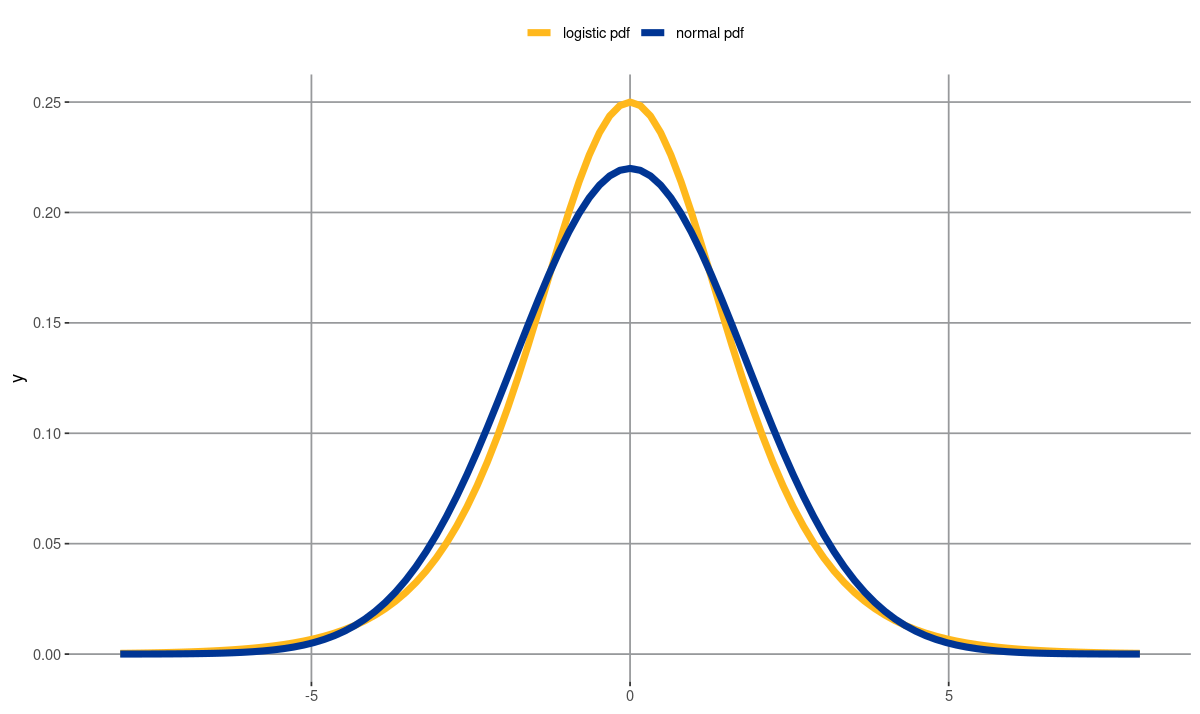

In [13]:
base +
geom_function( fun = dlogis,args=list(location=0,scale=1),aes(color="logistic pdf"), linewidth=2, )+
geom_function( fun = dnorm,args=list(mean=0,sd=pi/sqrt(3)),aes(color="normal pdf"), linewidth=2, )+
scale_color_manual(name='',values=c("normal pdf"= Pitt.Blue, "logistic pdf"= Pitt.Gold) )+xlim(-8,8)+theme(legend.position='top')

Note, that the standard logistic function with mean zero and scale parameter 1 has a variance of $\pi^2/3$, so I played with the normal above to match the variances.

But neither scale nor normalization matter when we think about Utilities because they're inherently comparative:
* There's no natural unit of utility, and if there was, all that matters is the comparison
    * If $u(A)$ is greater than $u(B)$, with respect to the choice between $A$ and $B$ it doesn't matter whether $A$ produces 10 happiness units or 20 million happiness units, $A$ will still be chosen over $B$
* Similarly, because it's comparative, we can normalize one of our utilities to zero (here $u(B)=0$) so that all utility is relative to $B$.

Because of this, we can just set the scale parameter to 1 and forget about it 

## Other distributions for the error term
Given that we use essentially any error distribution we want, why should we use the logistic?
* Well, the main reason is tractability, that the logistic is easy to interpret the coefficients
* But, the actual distribution of the error term isn't too distinct from a Normal

Still, given how much we like Normal distributions, there is a case to be made for changing the distribution of $\epsilon_i$ in the latent variable model to be a Normal (where again, because scale is not identified, we can set $\sigma=1$ for the errors). The main effect of this is to change the link function in the GLM.

This approach to having the errors be normal is called a **Probit** model (in comparison to 'logit' when the error has a logistic distribution). Fortunately this type of model is easy enough to estimate:

In [14]:
probit.est <- glm(own.multiple.cars~married+log(hh.income),data=data.Bernoulli, 
                  family= 'binomial'(link="probit") )
beta.probit <- coef(probit.est)
summary(probit.est)


Call:
glm(formula = own.multiple.cars ~ married + log(hh.income), family = binomial(link = "probit"), 
    data = data.Bernoulli)

Coefficients:
               Estimate Std. Error z value Pr(>|z|)    
(Intercept)    -4.17752    0.56958  -7.334 2.23e-13 ***
married1        1.33746    0.08995  14.868  < 2e-16 ***
log(hh.income)  0.31666    0.05511   5.746 9.12e-09 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1368.3  on 999  degrees of freedom
Residual deviance: 1062.0  on 997  degrees of freedom
AIC: 1068

Number of Fisher Scoring iterations: 4


While the assumptions on the latent variable error term are more intuitive, the costs of the probit function are that thinking about the effects of the model are a bit more complex.

That is, we need to use the Normal CDF to interpret the effects!
$$\Pr\left\{y_i=1\right\} = 1-\Phi(-x^T_i \hat{\beta}) $$

While there can be differences in the tails (and there will be some additional advantages in more-general contexts), in many cases the models will have very similar effects

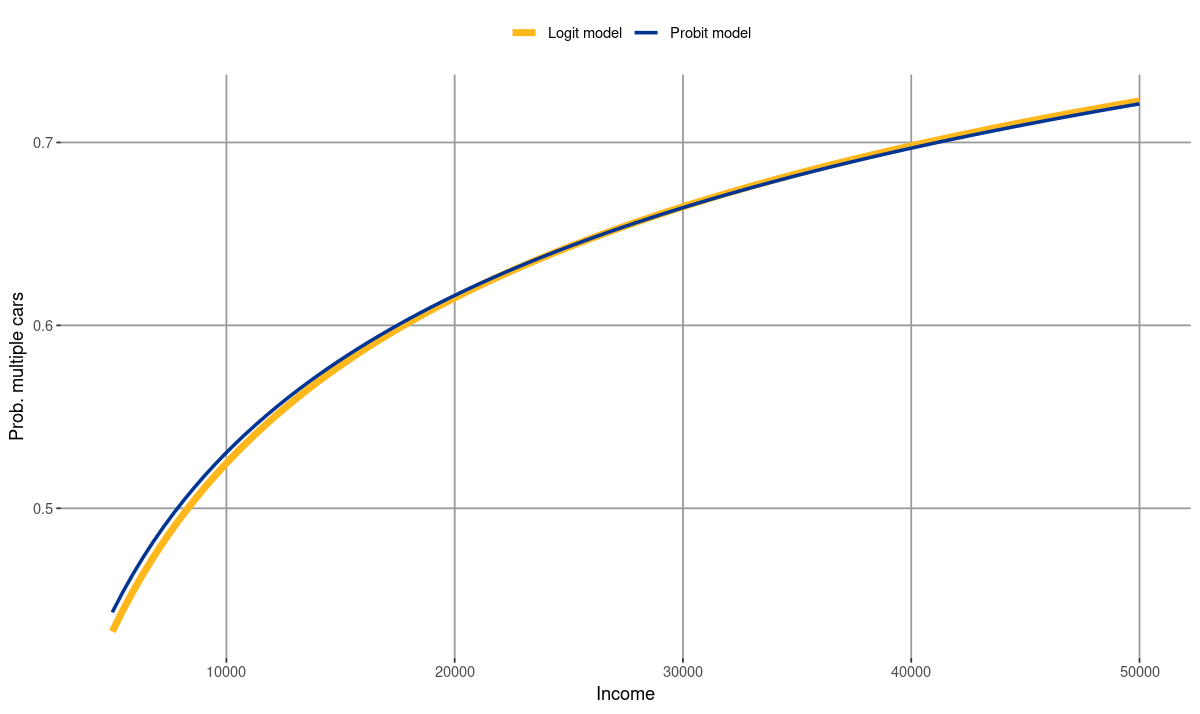

In [15]:
est.prob.multiple.probit <- function(income,married=FALSE)  1-pnorm(-(beta.probit[1]+married*beta.probit[2] +beta.probit[3]*log(income))  )
base + geom_function( fun = est.prob.multiple,args=list(married=TRUE), aes(colour="Logit model"), linewidth=2) +
geom_function( fun = est.prob.multiple.probit,args=list(married=TRUE), aes(colour="Probit model"), linewidth=1) +
xlim(5000, 50000)+ylab("Prob. multiple cars")+xlab("Income")+
scale_color_manual(name='',values=c("Probit model"= Pitt.Blue, "Logit model"= Pitt.Gold) )+theme(legend.position='top')

Stepping back, both non-linear models are taking our  linear predictor $\eta=x_i^T \beta$ which can take values in $(-\infty,\infty)$ and mapping it into a probability in $[0,1]$

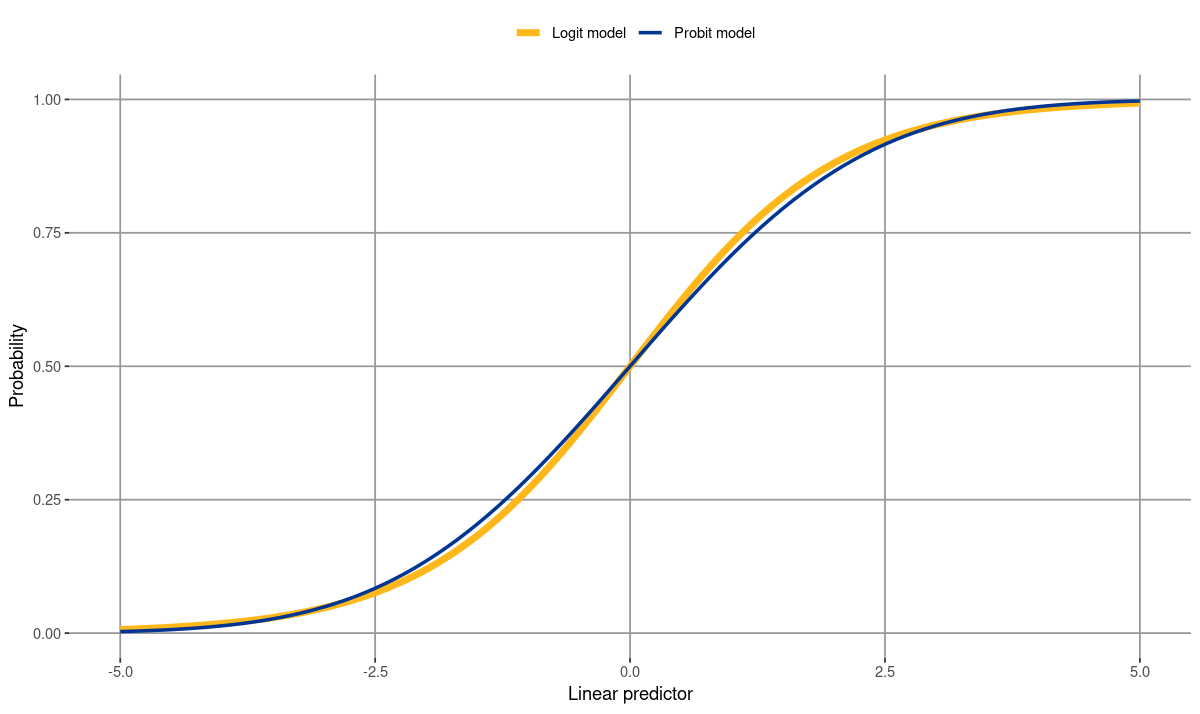

In [16]:
base + geom_function( fun = function(x) exp(x)/(exp(x)+1) , aes(colour="Logit model"), linewidth=2) +
geom_function( fun = function(x) 1-pnorm(-x/(pi/sqrt(3))) , aes(colour="Probit model"), linewidth=1) +
xlim(-5, 5)+ylab("Probability")+xlab("Linear predictor") + theme(legend.position='top')+
scale_color_manual(name='',values=c("Probit model"= Pitt.Blue , "Logit model"= Pitt.Gold) )

While the probit and logit models are relatively similar, they are distinct from the linear probability model you looked at earlier in the program:

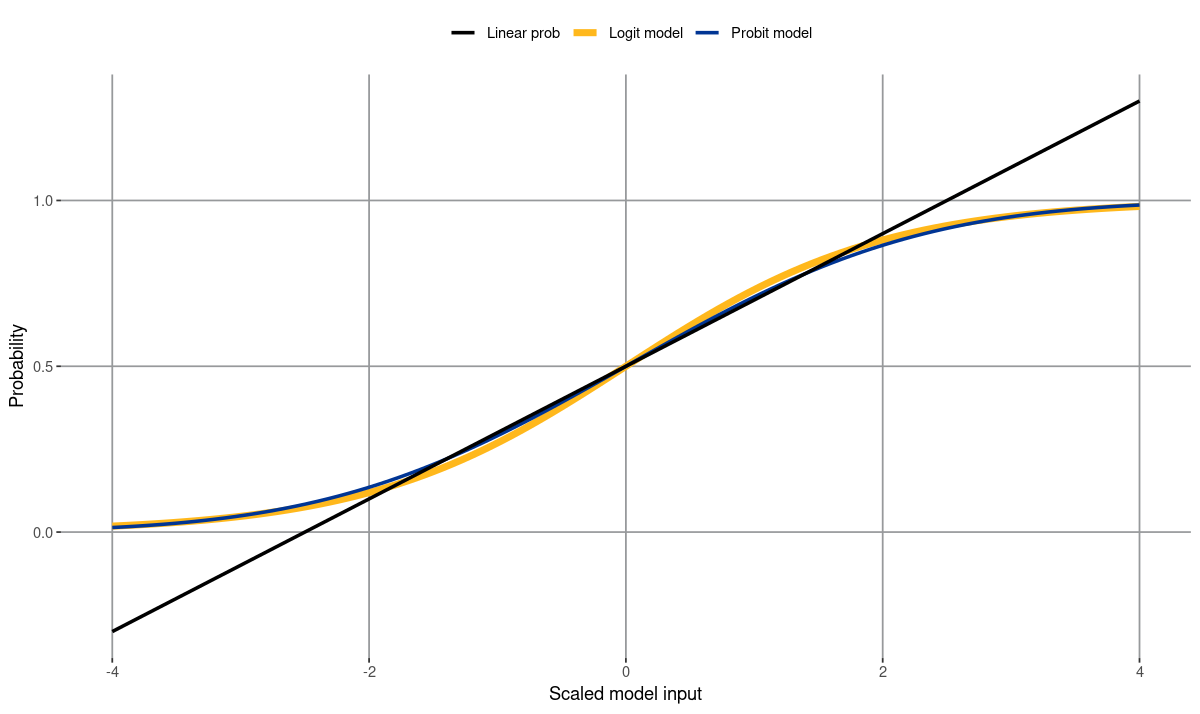

In [17]:
base + geom_function( fun = function(x) exp(x)/(exp(x)+1) ,  aes(colour="Logit model"), linewidth=2) +
geom_function( fun = function(x) 1-pnorm(-x/(pi/sqrt(3))) , aes(colour="Probit model"), linewidth=1) +
geom_function( fun = function(x) x/5+0.5 , aes(colour="Linear prob"), linewidth=1)+
xlim(-4, 4)+ylab("Probability")+xlab("Scaled model input")+theme(legend.position='top')+
scale_color_manual(name='',values=c("Probit model"= Pitt.Blue, "Logit model"= Pitt.Gold,"Linear prob"= "black") )

## Example with actual data
Attached is a dataset of every single field goal attempt in the NFL for 2009--19 (I grabbed the regular season play-by-play data from [here](https://github.com/ryurko/nflscrapR-data))
And then put it together with:

In [18]:
colndames(FieldGoalData)

ERROR: Error in eval(expr, envir, enclos): object 'FieldGoalData' not found


In [19]:
load(file="nfl/fg.rdata") # This loads a dataframe called FieldGoalData! 
head(FieldGoalData)
nrow(FieldGoalData)

play_id,game_id,home_team,away_team,posteam,posteam_type,defteam,side_of_field,yardline_100,game_date,⋯,penalty_yards,replay_or_challenge,replay_or_challenge_result,penalty_type,defensive_two_point_attempt,defensive_two_point_conv,defensive_extra_point_attempt,defensive_extra_point_conv,year,post_season
<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<date>,⋯,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<lgl>
522,2009091000,PIT,TEN,TEN,away,PIT,PIT,19,2009-09-10,⋯,NA,0,NA,NA,0,0,0,0,2009,FALSE
1633,2009091000,PIT,TEN,TEN,away,PIT,PIT,13,2009-09-10,⋯,NA,0,NA,NA,0,0,0,0,2009,FALSE
3179,2009091000,PIT,TEN,TEN,away,PIT,PIT,27,2009-09-10,⋯,NA,0,NA,NA,0,0,0,0,2009,FALSE
3527,2009091000,PIT,TEN,PIT,home,TEN,TEN,14,2009-09-10,⋯,NA,0,NA,NA,0,0,0,0,2009,FALSE
4250,2009091000,PIT,TEN,PIT,home,TEN,TEN,15,2009-09-10,⋯,NA,0,NA,NA,0,0,0,0,2009,FALSE
213,2009091304,CLE,MIN,CLE,home,MIN,MIN,20,2009-09-13,⋯,NA,0,NA,NA,0,0,0,0,2009,FALSE


[1] 11106

This still has way more columns than we need, so let's focus on building a relatively simple model of the probability that a field goal is good. This outcome variable is stored in `field_goal_result`

In [20]:
unique(FieldGoalData$field_goal_result)

[1] "missed"  "blocked" "made"

In [21]:
FG.not.blocked <- subset(FieldGoalData,field_goal_result!="blocked")
FG.not.blocked["fg_good"] <- ifelse(FG.not.blocked$field_goal_result=="made",TRUE,FALSE)

We're going to begin our model with a single variable, the distance to goal:
* The distance from the goal (`yardline_100`)

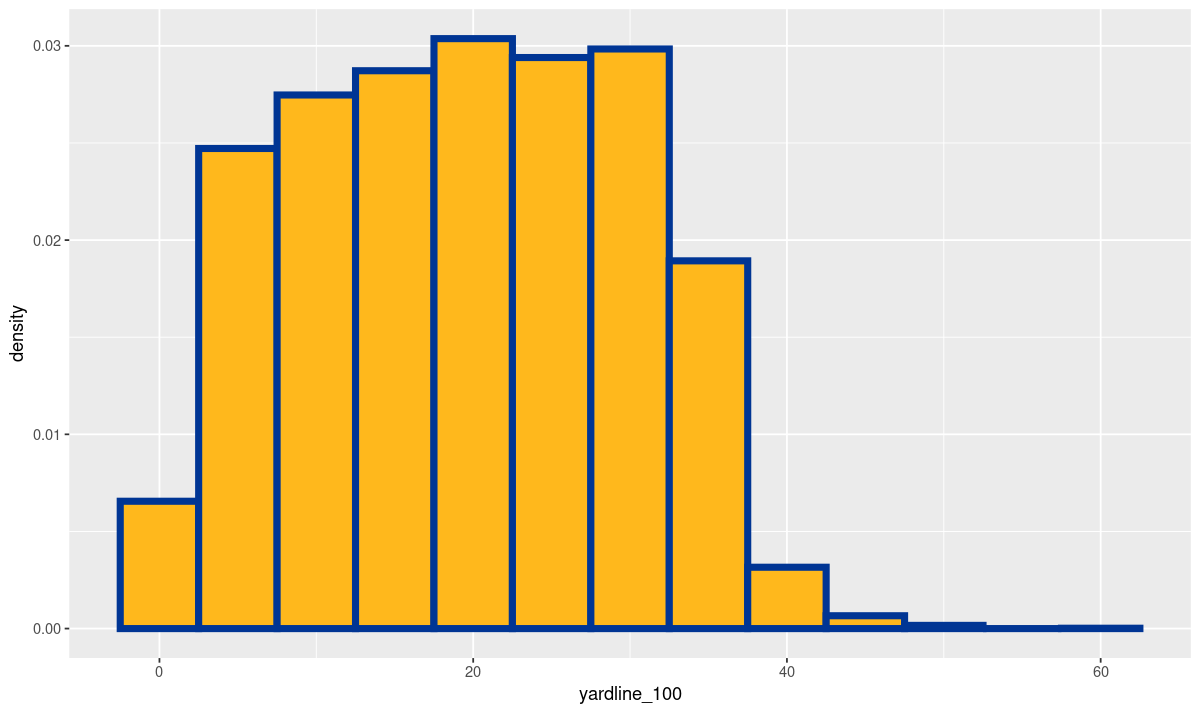

In [22]:
ggplot(FG.not.blocked,aes(x=yardline_100))+geom_histogram(binwidth=5,color=Pitt.Blue,fill=Pitt.Gold, linewidth=2,aes(y=after_stat(density)))

Let's look at the density plots of the Made and Missed Field goals with a violin plot:

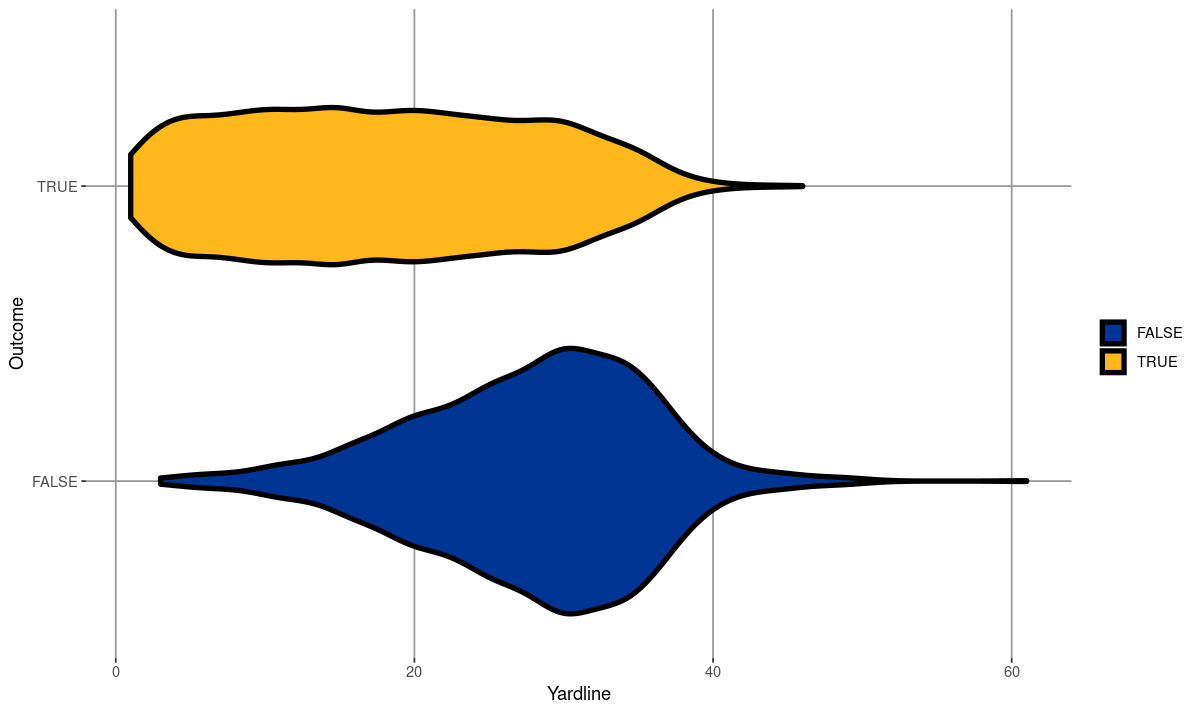

In [23]:
ggplot(FG.not.blocked,aes(x=fg_good,y=yardline_100,fill=fg_good))+geom_violin(color="black",linewidth=1.5)+
scale_fill_manual(name='',values=c("TRUE"= Pitt.Gold, "FALSE"= Pitt.Blue) )+ 
Pitt.Theme+ coord_flip() +ylab ("Yardline")+xlab("Outcome")

So, from the early part of the program, you'd probably be tempted to run a linear probability model here:

In [24]:
good.kick.lm <- lm( fg_good ~ yardline_100 , data=FG.not.blocked)
summary(good.kick.lm)


Call:
lm(formula = fg_good ~ yardline_100, data = FG.not.blocked)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.04687 -0.02355  0.09305  0.20965  0.45451 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)   1.0818541  0.0068321  158.35   <2e-16 ***
yardline_100 -0.0116600  0.0003104  -37.56   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.3316 on 10890 degrees of freedom
Multiple R-squared:  0.1147,	Adjusted R-squared:  0.1146 
F-statistic:  1411 on 1 and 10890 DF,  p-value: < 2.2e-16


But from what we've learned on max-likelihood and GLMs we can now model this binary outcome with either a logit or a probit model: (note that thinking about it as a *utility* here is a bit weird. Instead we would consider the $\epsilon$ as a luck term.) 

In [25]:
good.kick.logit  <- glm(fg_good~yardline_100, data=FG.not.blocked, family="binomial")
good.kick.probit <- glm(fg_good~yardline_100, data=FG.not.blocked, family='binomial'(link="probit"))

I want to graph the response, so I'm going to write a function that incorporates my model:

In [26]:
est.fg.lm <- function(yards, beta=coef(good.kick.lm)) beta["(Intercept)"]+beta["yardline_100"]*yards
est.fg.logit <- function(yards, beta=coef(good.kick.logit)) { 
    eta <- beta["(Intercept)"]+beta["yardline_100"]*yards
    exp(eta)/(1+exp(eta))
    }
est.fg.probit <- function(yards, beta=coef(good.kick.probit)) {
    eta <- beta["(Intercept)"]+beta["yardline_100"]*yards
    1-pnorm(-eta)
}


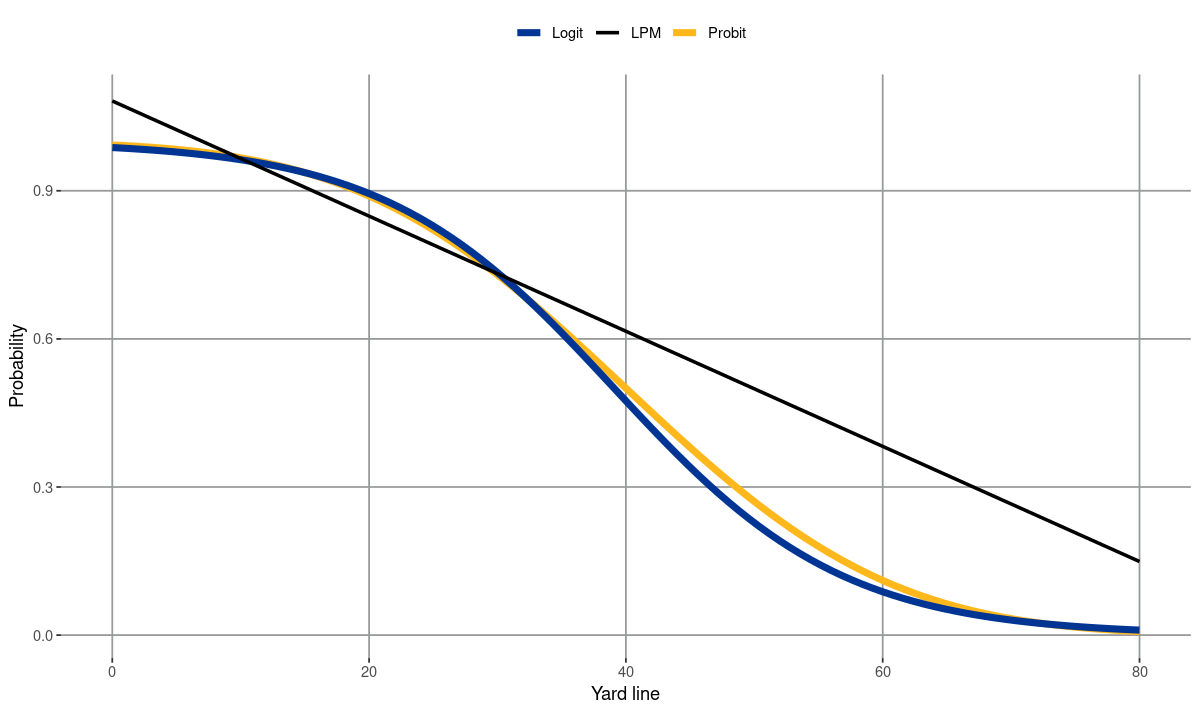

In [27]:
base+ 
geom_function( fun = est.fg.probit ,  aes(color="Probit"), linewidth=2)+
geom_function( fun = est.fg.logit ,  aes(color="Logit"), linewidth=2)+
geom_function( fun = est.fg.lm ,  aes(colour="LPM"), linewidth=1)+
xlim(0, 80)+ylab("Probability")+xlab("Yard line")+theme(legend.position='top') +
scale_color_manual(name='',values=c("Probit"= Pitt.Gold, "Logit"= Pitt.Blue,"LPM"= "black") )

The linear probability model does a fairly good job so long as we are looking at the large majority of field goal kicks. 

In [28]:
quantile( FG.not.blocked$yardline_100,c(0.1,0.9) )

10% 90% 
  5  33

Let's also look at what the data is telling us. Here I divide the actual data up into 5 yard bins: 

In [29]:
yd=seq(from=0, to=45, by=5)
ii=1
outMatrix<-matrix(ncol=2,nrow=length(yd))
for (val in yd) {
  outMatrix[ii,1] <- val+2.5 # midpoint of interval
  outMatrix[ii,2] <- mean(subset(FG.not.blocked, val<yardline_100 & yardline_100<=val+5)$fg_good)
  ii <- ii+1
}
outMatrix<- data.frame(outMatrix)
outMatrix

X1,X2
<dbl>,<dbl>
2.5,0.99319149
7.5,0.97878359
12.5,0.95564005
17.5,0.88639201
22.5,0.84009840
27.5,0.76187613
32.5,0.69812734
37.5,0.56338028
42.5,0.40677966


Overlaying this as a series of points on our graph:

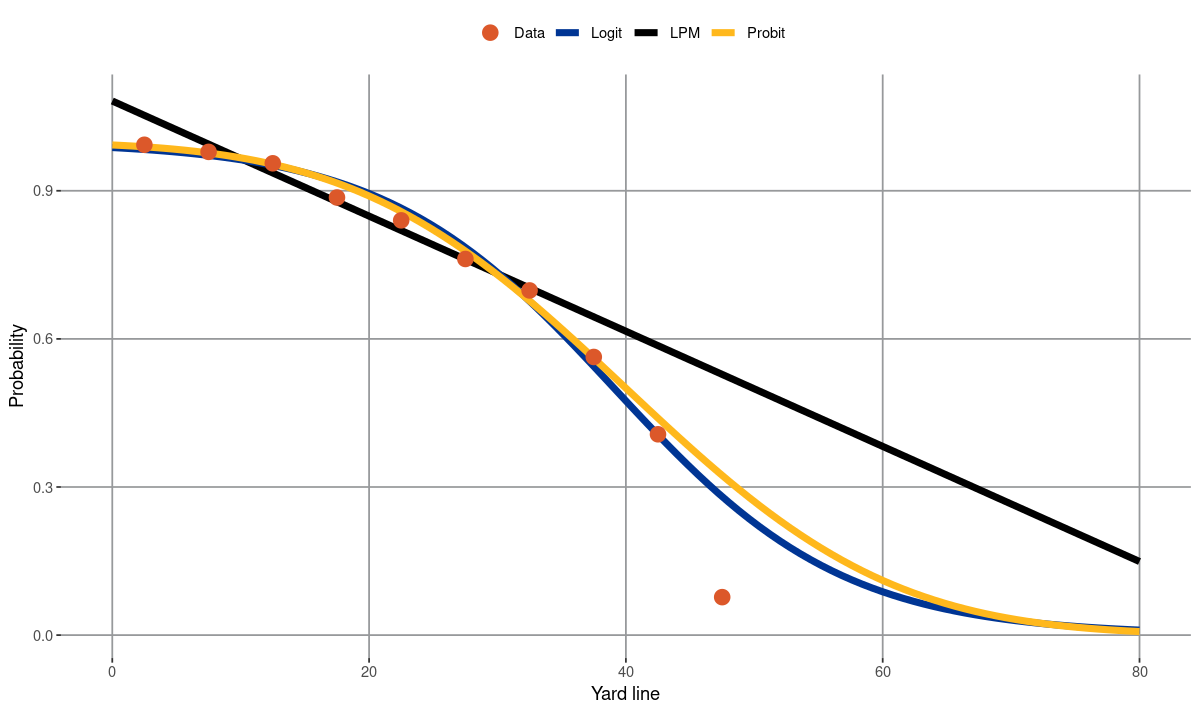

In [30]:
base+ geom_function( fun = est.fg.lm ,  aes(colour="LPM"), linewidth=2) +
geom_function( fun = est.fg.logit ,  aes(colour="Logit"), linewidth=2)+
geom_function( fun = est.fg.probit ,  aes(colour="Probit"), linewidth=2)+ xlim(0, 80)+ylab("Probability")+xlab("Yard line")+theme(legend.position='top')+
scale_color_manual(name='',values=c("Probit"= Pitt.Gold, "Logit"= Pitt.Blue,"LPM"= "black","Data"="#DC582A") )+
geom_point(data=outMatrix,aes(x=X1,y=X2,color="Data"),size=4)


So, even the non-linear models lack the ability to track the very large drop off in the chances once we reach the 50 yard line.

But because the GLM uses a linear model for the predictor we can leverage elements of our previous modeling options from linear models! 
* Let's just add in a term that will allow us to penalize really long attempts...

In [31]:
FG.not.blocked["yards_over_40"] <- ifelse(FG.not.blocked$yardline_100>40,
                                           FG.not.blocked$yardline_100-40,0)

Re-running the three models:

In [35]:
good.kick.lm.2 <- lm(fg_good~yardline_100+yards_over_40, data=FG.not.blocked)
good.kick.logit.2 <- glm(fg_good~yardline_100+yards_over_40, data=FG.not.blocked, family="binomial")
good.kick.probit.2 <- glm(fg_good~yardline_100+yards_over_40, data=FG.not.blocked, family='binomial'(link="probit"))
summary(good.kick.logit.2)


Call:
glm(formula = fg_good ~ yardline_100 + yards_over_40, family = "binomial", 
    data = FG.not.blocked)

Coefficients:
               Estimate Std. Error z value Pr(>|z|)    
(Intercept)    4.351599   0.097956  44.424   <2e-16 ***
yardline_100  -0.110901   0.003576 -31.011   <2e-16 ***
yards_over_40 -0.081808   0.066024  -1.239    0.215    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 9030.2  on 10891  degrees of freedom
Residual deviance: 7673.9  on 10889  degrees of freedom
AIC: 7679.9

Number of Fisher Scoring iterations: 5


And writing function to visualize the effects:

In [33]:
est.fg.lm.2 <- function( yards,beta=coef(good.kick.lm.2)) { 
   unname( beta["(Intercept)"]+beta["yardline_100"]*yards +beta["yards_over_40"]*ifelse(yards>40,yards-40,0) ) 
    }
est.fg.logit.2 <- function(yards,beta=coef(good.kick.logit.2)) { 
    eta <- beta["(Intercept)"]+beta["yardline_100"]*yards +beta["yards_over_40"]*ifelse(yards>40,yards-40,0)
    unname(exp(eta)/(1+exp(eta)))
    }
est.fg.probit.2 <- function(yards, beta=coef(good.kick.probit.2)) { 
    eta <- beta["(Intercept)"]+beta["yardline_100"]*yards +beta["yards_over_40"]*ifelse(yards>40,yards-40,0)
    unname(1-pnorm(-eta))
    }
est.fg.lm.2(12)

[1] 0.9407497

So we can illustrate the three models together as:

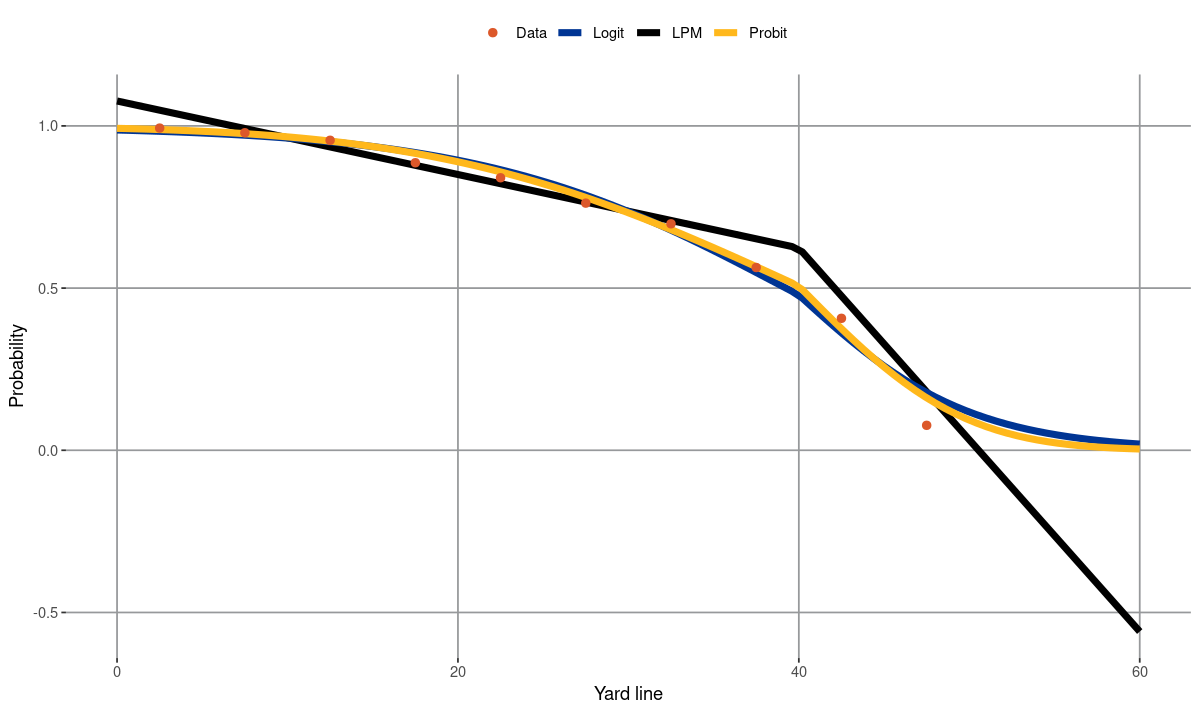

In [34]:
base+ geom_function( fun = est.fg.lm.2 ,  aes(colour="LPM"), linewidth=2) +
geom_function( fun = est.fg.logit.2 ,  aes(colour="Logit"), linewidth=2)+
geom_function( fun = est.fg.probit.2 ,  aes(colour="Probit"), linewidth=2)+
xlim(0, 60)+ylab("Probability")+xlab("Yard line")+theme(legend.position='top')+
scale_color_manual(name='',values=c("Probit"= Pitt.Gold, "Logit"= Pitt.Blue,"LPM"= "black","Data"="#DC582A") )+
geom_point(data=outMatrix,aes(x=X1,y=X2,color="Data"),size=2)

Especially as we add more terms to the model, explicitly forcing the model to be a well-defined probability will make more and more sense, as your predictions will tend to be better as you move away from the data averages.

The costs for this greater structure on the outcome variable is that you can not directly interpret the coefficients as you could with the linear-probability model

In [36]:
summary(good.kick.lm.2)


Call:
lm(formula = fg_good ~ yardline_100 + yards_over_40, data = FG.not.blocked)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.04273 -0.02007  0.09324  0.20656  0.73121 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)    1.0767239  0.0068711 156.702  < 2e-16 ***
yardline_100  -0.0113312  0.0003144 -36.036  < 2e-16 ***
yards_over_40 -0.0477838  0.0077538  -6.163 7.41e-10 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.3311 on 10889 degrees of freedom
Multiple R-squared:  0.1178,	Adjusted R-squared:  0.1176 
F-statistic: 726.9 on 2 and 10889 DF,  p-value: < 2.2e-16


This could be read off directly! A 1.1 percentage point drop in the probability for each yard away from the goal line... and a 5.7 percentage point drop for each yard beyond the 40

However, the model is incoherent when we try to predict a 55 yarder:

In [37]:
yd=seq(from=0, to=60, by=5)
round(data.frame("yds"=yd+2.5,"lpm"=est.fg.lm.2(yd),"logit"=est.fg.logit.2(yd),"probit"=est.fg.probit.2(yd)),3)

yds,lpm,logit,probit
<dbl>,<dbl>,<dbl>,<dbl>
2.5,1.077,0.987,0.992
7.5,1.020,0.978,0.983
12.5,0.963,0.962,0.966
17.5,0.907,0.936,0.936
22.5,0.850,0.894,0.889
27.5,0.793,0.829,0.821
32.5,0.737,0.736,0.732
37.5,0.680,0.615,0.624
42.5,0.623,0.479,0.506


In contrast, because the probit and logit models are non-linear, the effects from an increase/decrease in the yardage can only be figured out through the model.

Let's focus on the logit model and try to assess the effect of each additional yard!

In [38]:
yd=seq(from=1, to=60, by=5) 
data.frame("Yard.Line"=yd,"D.lpm"=est.fg.lm.2(yd-1)-est.fg.lm.2(yd),"D.logit"= -est.fg.logit.2(yd))

Yard.Line,D.lpm,D.logit
<dbl>,<dbl>,<dbl>
1,0.01133119,0.001470936
6,0.01133119,0.002510682
11,0.01133119,0.004224775
16,0.01133119,0.006941164
21,0.01133119,0.010966538
26,0.01133119,0.016293617
31,0.01133119,0.022111243
36,0.01133119,0.026560907
41,0.05911494,0.047749622


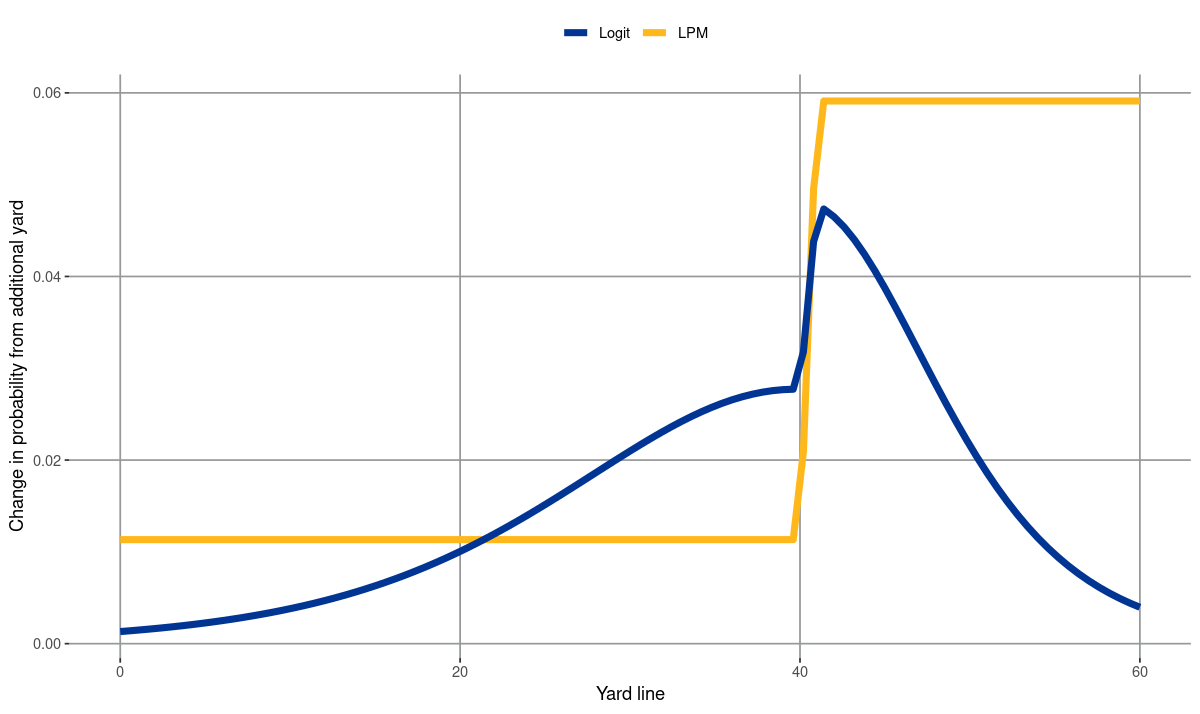

In [39]:
base+ geom_function( fun = function(x) est.fg.lm.2(x-1)-est.fg.lm.2(x) ,  aes(colour="LPM"), linewidth=2) +
geom_function( fun = function(x) est.fg.logit.2(x-1)-est.fg.logit.2(x) ,  aes(colour="Logit"), linewidth=2)+
xlim(0, 60)+ylab("Change in probability from additional yard")+xlab("Yard line")+theme(legend.position='top')+
scale_color_manual(name='',values=c("Logit"= Pitt.Blue,"LPM"= Pitt.Gold) )

Making the increment even smaller so it's more clearly a derivative:

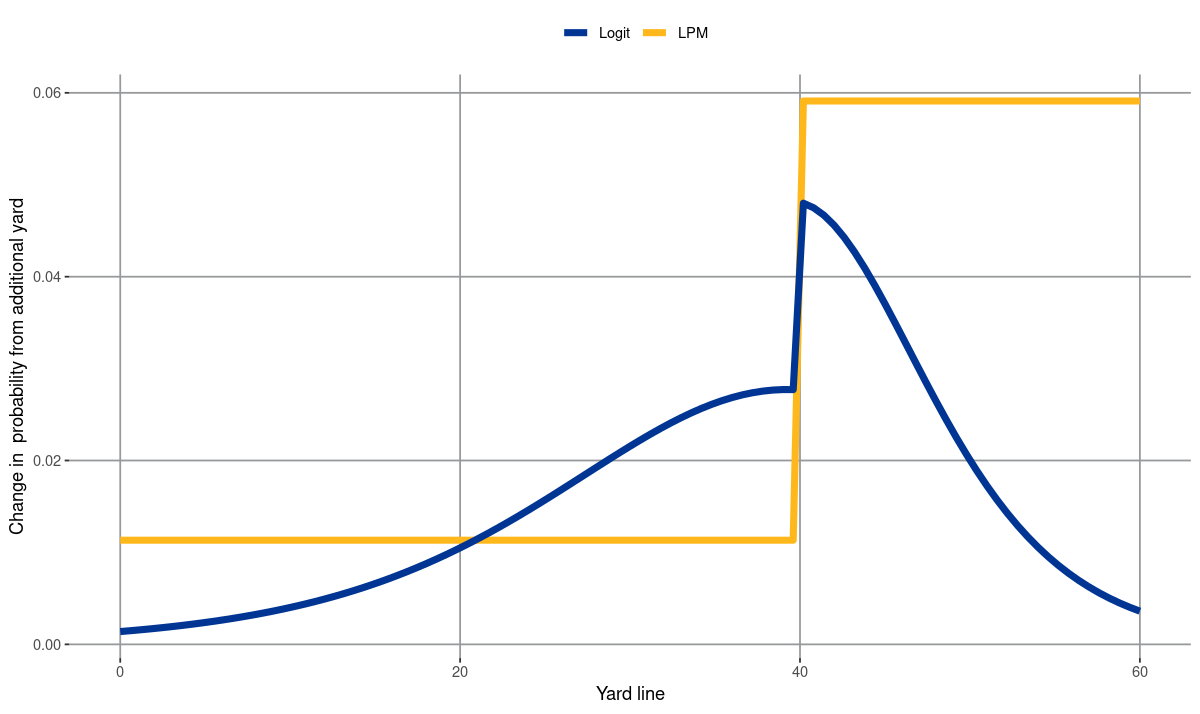

In [40]:
base+ geom_function( fun = function(x) (est.fg.lm.2(x- 1e-6)-est.fg.lm.2(x))/1e-6 ,  aes(colour="LPM"), linewidth=2) +
geom_function( fun = function(x) (est.fg.logit.2(x-1e-6)-est.fg.logit.2(x))/1e-6 ,  aes(colour="Logit"), linewidth=2)+
xlim(0, 60)+ylab("Change in  probability from additional yard")+xlab("Yard line")+theme(legend.position='top')+
scale_color_manual(name='',values=c("Logit"= Pitt.Blue,"LPM"= Pitt.Gold) )

## Marginal Effects
One way people get around the problem of the non-linearity in the model when communicating the parameters to others is to provide the marginal effects at the average.

That is for a parameter $\beta_i$ of a continuous variable $x_1$ we calculate the derivative for the model probability with respect to $x_i$ and report this effect at the data average.


If our model is $\beta_0+\beta_1 x_1+\beta_2 x_2$, the probability is:
$$\Pr\left\{y_i=1 |x_1,x_2\right\} =\frac{\exp(\beta_0+\beta_1 x_1+\beta_2 x_2)}{\exp(\beta_0+\beta_1 x_1+\beta_2 x_2)+1}$$

The marginal effect is then *(note: this is just algebra)*:
$$\frac{\partial}{\partial x_1}  \frac{\exp(\beta_0+\beta_1 x_1+\beta_2 x_2)}{\exp(\beta_0+\beta_1 x_1+\beta_2 x_2)+1}=\frac{\beta_1\cdot\exp(\beta_0+\beta_1 x_1+\beta_2 x_2)}{(\exp(\beta_0+\beta_1 x_1+\beta_2 x_2)+1)^2}$$

And then we assess this at the average values of $x_1$ and $x_2$:
$$\frac{\beta_1\cdot\exp(\beta_0+\beta_1 \bar{x}_1+\beta_2 \bar{x}_2)}{(\exp(\beta_0+\beta_1 \bar{x}_1+\beta_2 \bar{x}_2)+1)^2} $$

If instead the variable $x_1$ is a binary characteristic variable we would indicate the marginal effect via the discrete change:
$$\Pr\left\{y_i=1 |x_1=1,\bar{x}_2\right\}-\Pr\left\{y_i=1 |x_1=0,\bar{x}_2\right\} $$

Similarly, along with the change in the variable,  we can also calculate standard errors for the marginal effect using the delta method.

Fortunately, there's a package that makes our lives a little bit easier here: ([read more here](https://cran.r-project.org/web/packages/margins/vignettes/Introduction.html#Motivation))

In [48]:
#install.packages("margins") 
library(margins)

To use this I'm going to make the model of Field Goal success a bit richer by adding in a psychological variable: **Is the kick clutch?**

In [42]:
FG.not.blocked$last_seconds<-FG.not.blocked$game_seconds_remaining<30
FG.not.blocked$close_game<-( FG.not.blocked$posteam_score - FG.not.blocked$defteam_score>-3 & FG.not.blocked$defteam_score>=FG.not.blocked$posteam_score)
FG.not.blocked$high_pressure<-((FG.not.blocked$close_game * FG.not.blocked$last_seconds )==1)

So `high.pressure` captures situations where this is a game-winning kick.

Incorporating this into the model:

In [49]:
good.kick.logit.hp <- glm(fg_good ~ yardline_100+high_pressure, data=FG.not.blocked, family="binomial ")
summary(good.kick.logit.hp)


Call:
glm(formula = fg_good ~ yardline_100 + high_pressure, family = "binomial", 
    data = FG.not.blocked)

Coefficients:
                   Estimate Std. Error z value Pr(>|z|)    
(Intercept)        4.381288   0.096729  45.295  < 2e-16 ***
yardline_100      -0.111604   0.003498 -31.903  < 2e-16 ***
high_pressureTRUE -0.589549   0.176470  -3.341 0.000835 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 9030.2  on 10891  degrees of freedom
Residual deviance: 7665.1  on 10889  degrees of freedom
AIC: 7671.1

Number of Fisher Scoring iterations: 5


Use the `margins` command:

In [50]:
mean.yd=mean(FG.not.blocked$yardline_100)
summary( margins( good.kick.logit.hp, at = list(yardline_100=mean.yd, high_pressure=FALSE) ) )

,factor,yardline_100,high_pressure,AME,SE,z,p,lower,upper
,<chr>,<dbl>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,high_pressure,19.48458,FALSE,-0.066446564,0.0242258648,-2.742794,6.091884e-03,-0.11392839,-0.018964741
2,yardline_100,19.48458,FALSE,-0.009968281,0.0002658376,-37.497628,1.006823e-307,-0.01048931,-0.009447249


Figure out the average values of each:

In [51]:
mean.yd <- mean(FG.not.blocked$yardline_100) 
mean.hp <- mean(FG.not.blocked$high_pressure)
b <- coef(good.kick.logit.hp)

Calculate the marginal values as a check:

In [52]:
eta.mean.nhp <- unname(b[1]+b[2]*mean.yd)
eta.mean.hp <- unname(b[1]+b[2]*mean.yd+b[3])
c(
    "DProb.DYard"=unname(b[2])* exp( eta.mean.nhp )/( 1+exp(eta.mean.nhp) )**2,
    "DeltaProb.HighPressure"=
 exp( eta.mean.hp )/( 1+exp(eta.mean.hp) )-exp( eta.mean.nhp )/( 1+exp(eta.mean.nhp) ) 
 )

DProb.DYard DeltaProb.HighPressure 
          -0.009968281           -0.066446564

Even better than these marginal effects at the means though are averages across the marginal effects. That is, we can calculate the marginal effect of an increase/decrease in *each* variable, and for every single data observation $i$. 

So this would give us:
$$ \left( \left.\frac{\partial \Pr\left\{ y_i=1 | x_{1},x_{2} \right\}}{\partial x_1}\right|_{x_{i1},x_{i2}},  \left.\frac{\partial \Pr\left\{ y_i=1 | x_{1},x_{2} \right\}}{\partial x_2}\right|_{x_{i1},x_{i2}} \right) $$

for every single person $i$. And then we can take averages over this to get the *average marginal effect*.

Again, we benefit from there being a library to do this:

In [53]:
summary( margins( good.kick.logit.hp, type='response' ) )

,factor,AME,SE,z,p,lower,upper
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,high_pressure,-0.07337078,0.0248295168,-2.954982,3.126872e-03,-0.12203574,-0.02470582
2,yardline_100,-0.01203051,0.0003458232,-34.788035,3.689394e-265,-0.01270831,-0.01135271
